# Training and testing

> This notebook contains the pipeline for training and testing of **Random Forest** models for the **unsampled**, **undersampled**, **oversampled/SMOTE**, and **Selection of Random 5000 inactives** . 


## Utilities

In [1]:
"""Utility functions to perform common tasks"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE



def sep_features_and_target(df, target = 'Activity'):
    """Divide the dataframe into X and y

    Args:
        df (pandas.DataFrame): The dataset
        target (str, optional): The target variable. Defaults to 'Activity'.

    Returns:
        X (pandas.DataFrame): The feature matrix of the dataset
        y (pandas.Series): The target variable of the dataset
    """
    X = df.drop([target], axis = 1)
    y = df[target]

    return X, y


def visualize_class_distribution(target):
    """Divide the dataframe into X and y and Visualize the class distribution of a dataset

    Args:
        target(pandas.Series): The target variable of the dataset

    Returns:
        pandas.Series: The class distribution (value counts)
        Shows the class distribution of the dataset
    """

    target.value_counts().plot(kind = 'pie', autopct = '%.3f%%', figsize = (3, 3))
    
    output = f'{target.value_counts()[0]} Inactive Compounds, {target.value_counts()[1]} Active Compounds'
    print(output)

def train_test(X, y, test_size = 0.2, random_state = 42):
    """Split a dataset into train and test sets and visualize the distribution of classes in the trainsets

    Args:
        X (pandas.DataFrame): The feature matrix of a dataset
        y (pandas.Series): The target variable of a dataset
        test_size (float, optional): The size of the test set. Defaults to 0.2.

    Returns:
        X_train (pandas.DataFrame): The feature matrix of the training set
        X_test (pandas.DataFrame): The feature matrix of the test set
        y_train (pandas.Series): The target variable of the training set
        y_test (pandas.Series): The target variable of the test set

    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

    # visualize_class_distribution(y_train)
    

    print(f'Trainset ---> {y_train.value_counts()[0]} Inactive Compounds, {y_train.value_counts()[1]} Active Compounds')
    print(f'Testset ---> {y_test.value_counts()[0]} Inactive Compounds, {y_test.value_counts()[1]} Active Compounds')

    return X_train, X_test, y_train, y_test 
    

def variance_filter(X_train, X_test, threshold = 0.0):
    """Remove features with low variance

    Args:
        train (pandas.DataFrame): The training set
        test (pandas.DataFrame): The test set
        threshold (float, optional): The threshold for variance. Defaults to 0.0.

    Returns:
        pandas.DataFrame: The filtered training set
        pandas.DataFrame: The filtered test set
    """
    
    print(f'Initial Shapes: X_train ---> {X_train.shape}, X_test ---> {X_test.shape}')
    
    vt = VarianceThreshold(threshold = threshold)
    
    #Fit
    _ = vt.fit(X_train)
    
    # Get the mask
    mask = vt.get_support()
    
    #Subset the DataFrame

    X_train = X_train.loc[:, mask]
    X_test = X_test.loc[:, mask]
    
    print(f'After Filter: X_train ---> {X_train.shape}, X_test ---> {X_test.shape}')

    return X_train, X_test, mask

def undersampler(X_train, y_train, ratio = 0.5, random_state = 42):
    """Undersample the training set

    Args:
        X_train (pandas.DataFrame): The feature matrix of the training set
        y_train (pandas.Series): The target variable of the training set
        ratio (float): sampling strategy for random undersampling.

    Returns:
        X_train (pandas.DataFrame): The feature matrix of the training set
        y_train (pandas.Series): The target variable of the training set
    """
    rus = RandomUnderSampler(sampling_strategy = ratio, random_state = random_state)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    print(f'Trainset ---> {y_train.value_counts()[0]} Inactive Compounds, {y_train.value_counts()[1]} Active Compounds')
    
    return X_train, y_train

def oversampler(X_train, y_train, ratio = 0.5, random_state = 42):
    """Over sample the training set with SMOTE
    
    Args:
        X_train (pandas.DataFrame): The feature matrix of the training set
        y_train (pandas.Series): The target variable of the training set
        ration = ratio of minority class to majority class
        
    Returns:
        X_train (pandas.DataFrame): The feature matrix of the training set
        y_train (pandas.Series): The target variable of the training set
    """
    sm = SMOTE(sampling_strategy = ratio, random_state = random_state)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    
    print(f'Trainset ---> {y_train.value_counts()[0]} Inactive Compounds, {y_train.value_counts()[1]} Active Compounds')
    
    return X_train, y_train

def random_five_thousand(df, num = 5000):
    """Dataframe with 5000 inactive compounds and all active compounds

    Args:
        df (dataframe): the dataframe for the training data
        
    Returns:
        df (dataframe): the dataframe for the training data containing 5000 inactive plus all active compounds
    """
    
    df_0 = df.query('Activity == 0')
    df_1 = df.query('Activity == 1')
    
    print(f'Initial Number of Compounds: Inactives ---> {len(df_0)}, Actives ---> {len(df_1)}')
    
    df_0 = df_0.sample(n = num, random_state = 42)
    
    print(f'Final Number of Compounds: Inactives ---> {len(df_0)}, Actives ---> {len(df_1)}')
    
    df = pd.concat([df_0, df_1], ignore_index=True)
    
    return df

def conf_matrix(y,predictions):
    """ Plot a confusion matrix

    Arguments: 
        * y: the true labels... either train or test
        * predictions: the predicted labels... either train or test

    Returns:
        * Displays a confusion matrix
    """
    cm = confusion_matrix(y, predictions)

    cm_display = ConfusionMatrixDisplay(cm, display_labels = [False, True])
    cm_display.plot()
    plt.show()




In [2]:
"""Training"""
"""
This file contains code for performing cross validation and outputting the 
cross-validation metrics in a dataframe and a confusion matrix. 

The conf_matrix function is imported from the utility.py file.

"""
# Useful imports 
import pandas as pd 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, make_scorer, matthews_corrcoef
from sklearn.model_selection import cross_validate
#from utility import conf_matrix


def cross_validated(classifier, k, X_train, y_train, iteration):
    """
    This function runs a k-fold cross-validation on an input estimator(classifier). 
    It then returns the mean of the cross-validation metrics as a dataframe that can be easily merged with 
    that of other models.
    It also trains the model and returns it. 

    Arguments:

        * estimator = the classifier or algorithm to use. eg. RandomForestClassifier(n_jobs=-1)
        * k = how many fold the validation should be. Default value is 5
        
        * X_train = training set
        * y_train = training set labels
        

    Returns:
        
        * Means of the cross-validation metrics provided to the scoring argument 
        * Trained model 
    """
    # Define the cross-validation scoring metrics
    # MCC function using the make_scorer function
    mcc_scoring = make_scorer(matthews_corrcoef)

    #define the scoring metrices you would be using
    scoring_metrics = {'accuracy':'accuracy',
                       'balanced_accuracy':'balanced_accuracy',
                       'precision': 'precision',
                       'recall':'recall',
                       'f1': 'f1',
                       'roc_auc': 'roc_auc',
                        'mcc': mcc_scoring}
    
    # Run the cross-validation and store the result in a variable 
    cv_results = cross_validate(classifier, X_train, y_train, cv=k, scoring=scoring_metrics, n_jobs=-1)

    #Calculate the means of each fold and put it in a dictionary 
    cv_metrics_means_dict = {'Model': classifier.__class__.__name__, 'Process': 'Cross-Validation', 'Iteration': iteration}
    for metric in cv_results.keys():
        cv_metrics_means_dict[metric] = cv_results[metric].mean()
    
    # Convert the dictionary to a dataframe
    cv_metrics_means_df = pd.DataFrame(cv_metrics_means_dict, index=[0])

    #change the names of the metric columns for uniformity
    cv_metrics_means_df.rename(columns={'fit_time':'Fit Time (s)', 
                                        'score_time':'Score Time (s)',
                                          'test_accuracy':'Accuracy',
                                        'test_balanced_accuracy': 'Balanced Accuracy',
                                        'test_precision':'Precision',
                                            'test_recall':'Recall', 
                                            'test_f1':'F1-Score', 
                                            'test_roc_auc':'AUROC', 
                                            'test_mcc':'MCC'}, inplace=True)

    #train the model
    classifier.fit(X_train, y_train)

    #make predictions on the training data
    train_predictions = classifier.predict(X_train)

    #plot the confusion matrix
    conf_matrix(y_train, train_predictions)


    return cv_metrics_means_df, classifier





In [3]:
"""Testing"""

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,balanced_accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
#from utility import conf_matrix

def evaluate_model(model, X_test, y_test, iteration):
    """Evaluate a model

    Args:
        model (sklearn.model): The model to be evaluated
        X_test (pandas.DataFrame): The feature matrix of the test set
        y_test (pandas.Series): The target variable of the test set

    Returns:
        float: The accuracy of the model
        float: The precision of the model
        float: The recall of the model
        float: The f1-score of the model
    """
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    # if model is svm model use decision function instead of predict proba
    if model.__class__.__name__ == 'SVC':
        pred_prob = model.decision_function(X_test)
        auroc = roc_auc_score(y_test, pred_prob) 
    else:
        pred_prob = model.predict_proba(X_test)[:, 1]
        auroc = roc_auc_score(y_test, pred_prob)
    
    # print(f'Accuracy: {accuracy}')
    # print(f'Precision: {precision}')
    # print(f'Recall: {recall}')
    # print(f'F1-Score: {f1}')
    # print(f'MCC: {mcc}')
    # print(f'AUROC: {auroc}')
    
    results = {'Model': model.__class__.__name__, 'Process':'Testing', 'Iteration': iteration,'Accuracy': accuracy, 'Balanced Accuracy':balanced_accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'MCC': mcc, 'AUROC': auroc}
    df = pd.DataFrame(results, index = [0])
    
    # confusion matrix
    conf_matrix(y_test, y_pred)
    
    # cm = confusion_matrix(y_test, y_pred)
    
    # cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])    
    
    # cm_display.plot()
    # plt.show()
    return df, pred_prob

## Imports

In [6]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 764.7 kB/s eta 0:00:0000:0100:06


In [4]:
## Importing Libraries
# useful imports 

import numpy as np 
import pandas as pd 
#from utility import *
#from train import * 
#from test import * 
import os 
import pickle

#import random forest calssifier from sklearn library

import xgboost
from sklearn.model_selection import GridSearchCV, cross_validate

%reload_ext autoreload
%autoreload 2

## Preliminary Actions


In [5]:
#load in the data
df = pd.read_csv('../Data/final_dataset.csv')
df.head(5)


,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,Activity
0,2,0,0,2,3,0,0,0,0,0,...,0,0,0,0,0,5.267,-0.711,0.379,1.885,1
1,2,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,5.426,-0.712,0.353,5.617,1
2,3,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,5.883,-0.678,0.383,8.837,1
3,3,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,5.807,-0.703,0.409,7.934,1
4,3,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,5.833,-0.710,0.400,7.255,1


In [6]:
#divide the data into X and y
X, y = sep_features_and_target(df)
print(X.shape)
print(y.shape)

(364292, 777)
(364292,)


## Unsampled 
> The training is done on the imbalanced data and tested with the test set. 

In [ ]:
#visualize the class distribution of the data
visualize_class_distribution(y)


In [ ]:
#split the data into testing and training sets 
X_train, X_test, y_train, y_test1 = train_test(X,y)


In [ ]:
#remove low variance features
X_train, X_test, mask1 = variance_filter(X_train, X_test)

In [ ]:
# #Begin Cross-Validation
# estimator = xgboost.XGBClassifier(random_state =42)
# Unsam_cv_df, classifier1 = cross_validated(estimator, 2, X_train, y_train, iteration = 'Unsampled')
 


In [ ]:
#show cross-validated metrics
Unsam_cv_df


### Testing


In [ ]:
# model testing on external data 
Unsam_test_df, pred_prob1 = evaluate_model(classifier1, X_test, y_test1, 'Unsampled')


In [ ]:
#show the test metrics
Unsam_test_df

## Undersampled
> the inactive set is undersampled using a random undersampler.


In [7]:
#split the data into testing and training sets
X_train, X_test, y_train, y_test2 = train_test(X,y)


Trainset ---> 289838 Inactive Compounds, 1595 Active Compounds
Testset ---> 72426 Inactive Compounds, 433 Active Compounds


In [8]:

#remove low variance features
X_train,X_test, mask2 = variance_filter(X_train, X_test)


Initial Shapes: X_train ---> (291433, 777), X_test ---> (72859, 777)
After Filter: X_train ---> (291433, 656), X_test ---> (72859, 656)


In [9]:
#perform undersampling of the data 
X_train, y_train= undersampler(X_train, y_train)


Trainset ---> 3190 Inactive Compounds, 1595 Active Compounds


3190 Inactive Compounds, 1595 Active Compounds


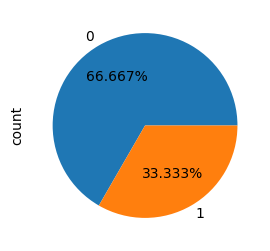

In [10]:
#visualize the class distribution of the data after undersampling
visualize_class_distribution(y_train)


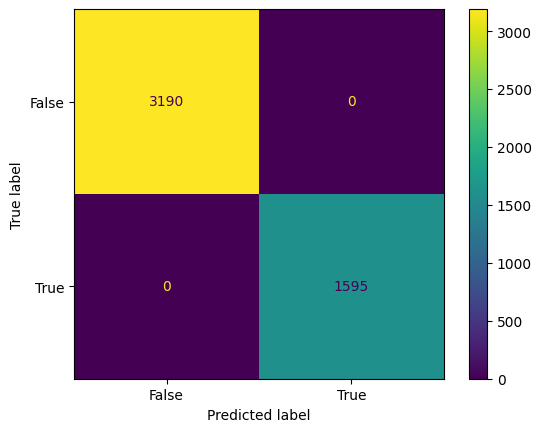

In [11]:
#Begin Cross-Validation
estimator = xgboost.XGBClassifier(random_state =42)
Undersam_cv_df, classifier2 = cross_validated(estimator, 10, X_train, y_train, iteration = 'Undersampled')

In [12]:
#show cross-validated metrics
Undersam_cv_df



,Model,Process,Iteration,Fit Time (s),Score Time (s),Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,AUROC,MCC
0,XGBClassifier,Cross-Validation,Undersampled,21.215964,0.067042,0.99415,0.992167,0.996222,0.986215,0.991183,0.999706,0.986845


### Testing


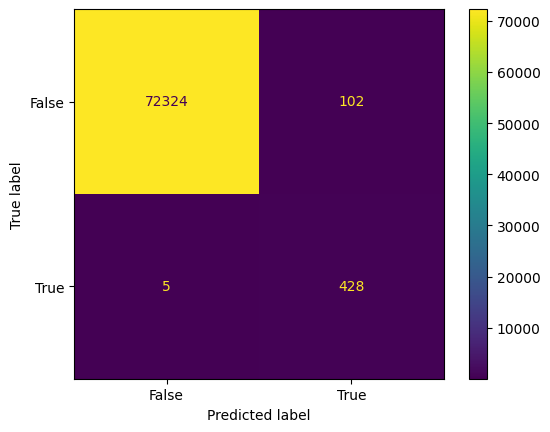

In [13]:
# model testing on external data 
Undersam_test_df, pred_prob2 = evaluate_model(classifier2, X_test, y_test2, 'Undersampled')


In [14]:
#show the test metrics
Undersam_test_df

,Model,Process,Iteration,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,MCC,AUROC
0,XGBClassifier,Testing,Undersampled,0.998531,0.993522,0.807547,0.988453,0.888889,0.892758,0.999857


## SMOTE

> The active set is oversampled using the Synthetic Minority Oversampling Technique (SMOTE)

In [ ]:
#split the data into testing and training sets
X_train, X_test, y_train, y_test3 = train_test(X,y)


In [ ]:
#remove low variance features
X_train, X_test, mask3 = variance_filter(X_train, X_test)


In [ ]:
# apply SMOTE to the data
X_train, y_train = oversampler(X_train, y_train)


In [ ]:
#visualize the class distribution of the data after undersampling
visualize_class_distribution(y_train)


In [ ]:
# #Begin Cross-Validation
# estimator = xgboost.XGBClassifier(random_state =42)
# smote_cv_df, classifier3 = cross_validated(estimator, 2, X_train, y_train, iteration = 'SMOTE')


In [ ]:
#show cross-validated metrics 

smote_cv_df


### Testing


In [ ]:
# model testing on external data
smote_test_df, pred_prob3 = evaluate_model(classifier3, X_test, y_test3, 'SMOTE')


In [ ]:
#show the test metrics
smote_test_df

## Random 5000 
> The inactive set is undersampled to 5000 samples and a new dataframe is generated from this with the same number of active samples.


In [15]:
#genrate a dataframe with random 5000 inactives from the original dataset 
df = random_five_thousand(df)


Initial Number of Compounds: Inactives ---> 362264, Actives ---> 2028
Final Number of Compounds: Inactives ---> 5000, Actives ---> 2028


In [16]:
#divide the data into X and y
X, y = sep_features_and_target(df)


In [17]:
#split the data into testing and training sets
X_train, X_test, y_train, y_test4 = train_test(X,y)


Trainset ---> 3982 Inactive Compounds, 1640 Active Compounds
Testset ---> 1018 Inactive Compounds, 388 Active Compounds


In [18]:
#remove low variance features
X_train, X_test, mask4 = variance_filter(X_train, X_test)


Initial Shapes: X_train ---> (5622, 777), X_test ---> (1406, 777)
After Filter: X_train ---> (5622, 629), X_test ---> (1406, 629)


3982 Inactive Compounds, 1640 Active Compounds


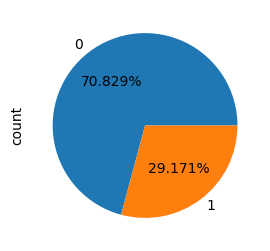

In [19]:

#visualize the class distribution of the data after undersampling
visualize_class_distribution(y_train)


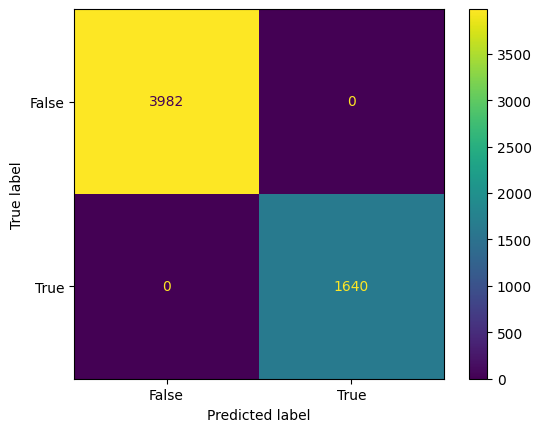

In [20]:
#Begin Cross-Validation
estimator = xgboost.XGBClassifier(random_state =42)
r5000_cv_df, classifier4 = cross_validated(estimator, 10, X_train, y_train, iteration = 'Random 5000')


In [21]:
#show cross-validated metrics 

r5000_cv_df


,Model,Process,Iteration,Fit Time (s),Score Time (s),Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,AUROC,MCC
0,XGBClassifier,Cross-Validation,Random 5000,24.68266,0.053674,0.996087,0.99401,0.997561,0.989024,0.993253,0.999916,0.990537


### Testing


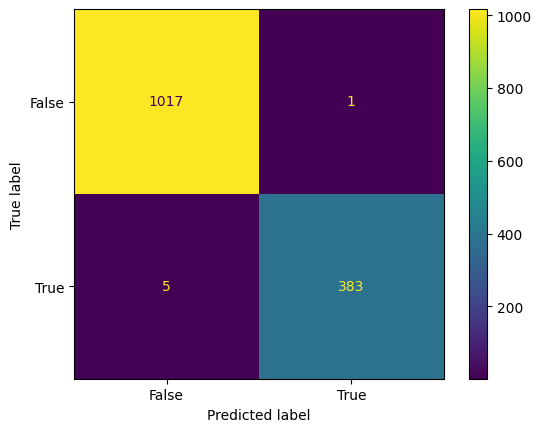

In [22]:
# model testing on external data
r5000_test_df, pred_prob4 = evaluate_model(classifier4, X_test, y_test4, 'Random 5000')


In [23]:
#show the test metrics
r5000_test_df

,Model,Process,Iteration,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,MCC,AUROC
0,XGBClassifier,Testing,Random 5000,0.995733,0.993066,0.997396,0.987113,0.992228,0.989312,0.999957


## Final Dataframe of all Trainining and Test Results

In [24]:
rf_final_results = pd.concat([Undersam_cv_df, Undersam_test_df, r5000_cv_df, r5000_test_df], axis=0, join='inner', ignore_index=True)

In [25]:
rf_final_results

,Model,Process,Iteration,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score,AUROC,MCC
0,XGBClassifier,Cross-Validation,Undersampled,0.994150,0.992167,0.996222,0.986215,0.991183,0.999706,0.986845
1,XGBClassifier,Testing,Undersampled,0.998531,0.993522,0.807547,0.988453,0.888889,0.999857,0.892758
2,XGBClassifier,Cross-Validation,Random 5000,0.996087,0.994010,0.997561,0.989024,0.993253,0.999916,0.990537
3,XGBClassifier,Testing,Random 5000,0.995733,0.993066,0.997396,0.987113,0.992228,0.999957,0.989312


In [26]:
#check if the results folder exists, if not create it

if not os.path.exists('../Results/XGB Results'):
    os.makedirs('../Results/XGB Results')

In [27]:
#save the total results to a csv file
rf_final_results.to_csv('../Results/XGB Results/XGBoost Results.csv')

## Save all models 

In [28]:
#check if the classifier folder exists, if not create it

if not os.path.exists('../Results/XGB Results/Classifiers'):
    os.makedirs('../Results/XGB Results/Classifiers')

In [29]:
#pickle.dump(classifier1, open('/kaggle/working/Results/Classifiers/classifier1', 'wb'))

pickle.dump(classifier2, open('../Results/XGB Results/Classifiers/classifier2', 'wb'))

#pickle.dump(classifier3, open('/kaggle/working/Results/Classifiers/classifier3', 'wb'))

pickle.dump(classifier4, open('../Results/XGB Results/Classifiers/classifier4', 'wb'))

## Save all Variance Threshold Masks 

In [30]:
#check if the masks folder exists, if not create it

if not os.path.exists('../Results/XGB Results/Masks'):
    os.makedirs('../Results/XGB Results/Masks')

In [31]:
#pickle.dump(mask1, open('/kaggle/working/Results/Masks/mask1', 'wb'))
pickle.dump(mask2, open('../Results/XGB Results/Masks/mask2', 'wb'))
#pickle.dump(mask3, open('/kaggle/working/Results/Masks/mask3', 'wb'))
pickle.dump(mask4, open('../Results/XGB Results/Masks/mask4', 'wb'))

## Save all Prediction Probabilities

In [32]:
#check if the pred_probabilities folder exists, if not create it

if not os.path.exists('../Results/XGB Results/Pred_Probabilities'):
    os.makedirs('../Results/XGB Results/Pred_Probabilities')

In [33]:
#pickle.dump(pred_prob1, open('/kaggle/working/Results/Pred_Probabilities/pred_prob1', 'wb'))
pickle.dump(pred_prob2, open('../Results/XGB Results/Pred_Probabilities/pred_prob2', 'wb'))
#pickle.dump(pred_prob3, open('/kaggle/working/Results/Pred_Probabilities/pred_prob3', 'wb'))
pickle.dump(pred_prob4, open('../Results/XGB Results/Pred_Probabilities/pred_prob4', 'wb'))

# ROC Plot 

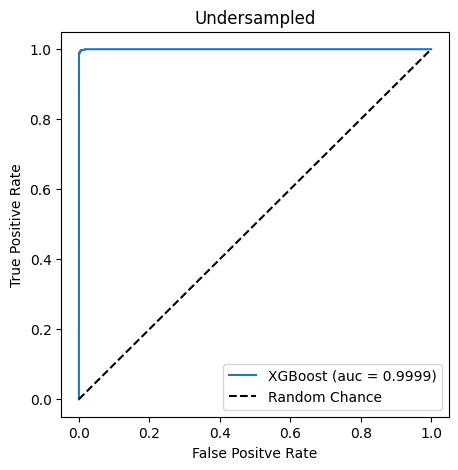

<Figure size 640x480 with 0 Axes>

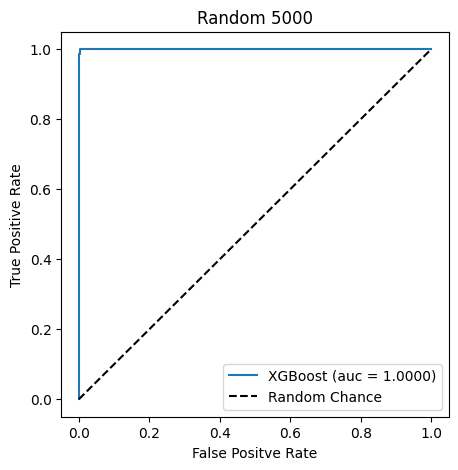

<Figure size 640x480 with 0 Axes>

In [34]:
#ROC plot for all the iterations
#import the auc function
from sklearn.metrics import auc, roc_curve

iterations = ['Undersampled','Random 5000']

#create a dictionary that maps each iteration to its y_test 
model_classifier_ytest = {
                   'Undersampled':y_test2,
                   
                   'Random 5000':y_test4}

#create a dictionary that maps each iteration to its pred_proba number 
model_classifier_proba = {
                   'Undersampled':pred_prob2,
                   
                   'Random 5000':pred_prob4}

# use a loop to make all the ROC Plots

for iteration in iterations:
    
    y_test = model_classifier_ytest[iteration]

    pred_proba = model_classifier_proba[iteration]

    #get the false positive and true positive rates
    fpr,tpr,threshold = roc_curve(y_test, pred_proba)

    #get the auc score using the auc funtion
    auc_score = auc(fpr, tpr)

    #go ahead to plot the roc 
    plt.figure(figsize = (5, 5), dpi = 100)

    plt.plot(fpr, tpr, label = 'XGBoost (auc = %0.4f)'%auc_score)
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Chance') #diagonal line
    
    plt.title(iteration)

    plt.xlabel('False Positve Rate')
    plt.ylabel('True Positive Rate')

    plt.legend()
    plt.show()

    plt.savefig('../Results/XGB Results/XGBoostROC'+iteration+'.png')